In [20]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
DTYPE='float32'

In [21]:
# Define the adaptive activation function
class AdaptiveActivation(tf.keras.layers.Layer):
    def __init__(self, activation_function):
        super(AdaptiveActivation, self).__init__()
        self.alpha = tf.Variable(1.0, trainable=True, dtype=tf.float32)  # Scalable hyperparameter
        self.activation_function = activation_function

    def call(self, x):
        return self.activation_function(self.alpha * x)

In [22]:
# Define the neural network
class PINN(tf.keras.Model):
    def __init__(self, layers, activation_function):
        super(PINN, self).__init__()
        self.layers_ = []
        for layer_width in layers[:-1]:
            self.layers_.append(tf.keras.layers.Dense(layer_width, activation=AdaptiveActivation(activation_function)))
        self.layers_.append(tf.keras.layers.Dense(layers[-1], activation=None))  # Output layer

    def call(self, x):
        for layer in self.layers_:
            x = layer(x)
        return x

In [23]:
# Define the residual of Burgers' equation
def burgers_residual(t, x, u, u_t, u_x, u_xx, nu=0.01/ tf.constant(np.pi, dtype=DTYPE)):
    return u_t + u * u_x - nu * u_xx

In [24]:
# Physics-informed loss
def loss_fn(model, t_x, X_ic, u_ic, X_bc):
    t = t_x[:, 0:1]
    x = t_x[:, 1:2]

    # Initial condition residual
    u_pred_initial = model(X_ic)
    loss_ic = tf.reduce_mean(tf.square(u_pred_initial - u_ic))

    # Boundary condition residual (u(t, 0) = u(t, 1) = 0)
    u_pred_left = model(X_bc['left'])
    u_pred_right = model(X_bc['right'])
    loss_bc = tf.reduce_mean(tf.square(u_pred_left)) + tf.reduce_mean(tf.square(u_pred_right))

    # PDE residual
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        u = model(tf.concat([t, x], axis=1))
        u_x = tape.gradient(u, x)
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    residual = burgers_residual(t, x, u, u_t, u_x, u_xx)
    loss_pde = tf.reduce_mean(tf.square(residual))

    return loss_pde + loss_ic + loss_bc

In [25]:
# Training function
def train_model(model, X_train, X_ic, u_ic, X_bc, epochs=1000, learning_rate=1e-3):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = loss_fn(model, X_train, X_ic, u_ic, X_bc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss.numpy()}')

In [31]:
# Define the grid of points (training data)
N = 100
T_max = 1.0
tspace = np.linspace(0, T_max, N)
xspace = np.linspace(-1, 1, N)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(), X.flatten()]).T

# Convert grid to TensorFlow tensor
X_train = tf.convert_to_tensor(Xgrid, dtype=tf.float32)

# Initial Condition: u(0, x) = sin(pi * x)
X_ic = np.vstack([np.zeros(N), xspace]).T  # t=0 for all x
u_ic = -np.sin(np.pi * X_ic[:, 1:2])        # -sin(pi * x)
X_ic = tf.convert_to_tensor(X_ic, dtype=tf.float32)
u_ic = tf.convert_to_tensor(u_ic, dtype=tf.float32)

# Boundary Condition: u(t, 0) = u(t, 1) = 0 for all t
X_bc_left = np.vstack([tspace, np.zeros(N)]).T   # x=0 for all t
X_bc_right = np.vstack([tspace, np.ones(N)]).T   # x=1 for all t
X_bc = {'left': tf.convert_to_tensor(X_bc_left, dtype=tf.float32),
        'right': tf.convert_to_tensor(X_bc_right, dtype=tf.float32)}

In [32]:
# Build the model
layers = [2, 50, 50, 50, 1]  # Neural network architecture
activation_function = tf.keras.activations.tanh  # Base activation function
model = PINN(layers, activation_function)

# Train the model
train_model(model, X_train, X_ic, u_ic, X_bc, epochs=2000, learning_rate=1e-3)

Epoch: 0, Loss: 0.4536195397377014
Epoch: 100, Loss: 0.211333230137825
Epoch: 200, Loss: 0.16001524031162262
Epoch: 300, Loss: 0.13845294713974
Epoch: 400, Loss: 0.11494147777557373
Epoch: 500, Loss: 0.10916608572006226
Epoch: 600, Loss: 0.10516650974750519
Epoch: 700, Loss: 0.10215472429990768
Epoch: 800, Loss: 0.09921664744615555
Epoch: 900, Loss: 0.09627864509820938
Epoch: 1000, Loss: 0.09356421232223511
Epoch: 1100, Loss: 0.09329219162464142
Epoch: 1200, Loss: 0.08813735842704773
Epoch: 1300, Loss: 0.08543703705072403
Epoch: 1400, Loss: 0.08855420351028442
Epoch: 1500, Loss: 0.08149456977844238
Epoch: 1600, Loss: 0.07652433216571808
Epoch: 1700, Loss: 0.07551934570074081
Epoch: 1800, Loss: 0.06798211485147476
Epoch: 1900, Loss: 0.06631099432706833


In [33]:
# Predictions
upred = model(X_train)
U_pred = upred.numpy().reshape(N, N)

Text(0.5, 0, '$u(t, x)$')

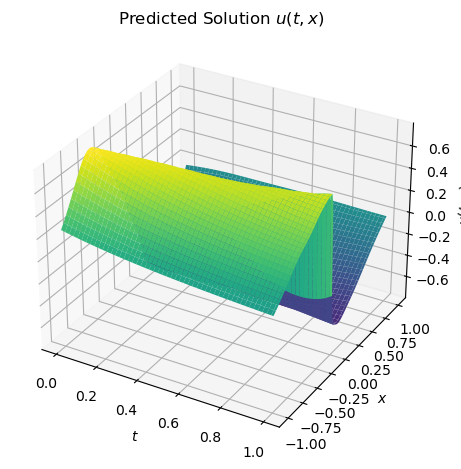

In [34]:
# Plot predicted vs exact solution
fig = plt.figure(figsize=(12, 6))

# Plot predicted solution
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T, X, U_pred, cmap='viridis')
ax1.set_title('Predicted Solution $u(t, x)$')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_zlabel('$u(t, x)$')

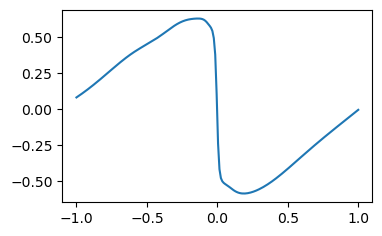

In [38]:
DTYPE='float32'
fig = plt.figure(figsize=(4,2.5))
tspace= 0.8
xspace = np.linspace(-1, 1, 200)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
plt.plot(X,upred)